1. Environment Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


2. Simple Language Model Definition

In [2]:
class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=128, num_layers=2):
        super(SimpleLanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, hidden_size)

        if hidden is None:
            lstm_out, hidden = self.lstm(embedded)
        else:
            lstm_out, hidden = self.lstm(embedded, hidden)

        output = self.output_layer(lstm_out)  # (batch_size, seq_len, vocab_size)
        return output, hidden

    def get_action_probabilities(self, state, temperature=1.0):
        """Get action probabilities for current state"""
        with torch.no_grad():
            output, _ = self.forward(state.unsqueeze(0))
            logits = output[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
        return probs.squeeze()

3. PPO Agent with veRL Components

In [3]:
class PPOVeRLAgent:
    def __init__(self, model, vocab_size, lr=1e-4, gamma=0.99, epsilon=0.2, beta=0.01):
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.vocab_size = vocab_size
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # PPO clip parameter
        self.beta = beta  # entropy coefficient

        # veRL components
        self.memory = deque(maxlen=10000)
        self.value_criterion = nn.MSELoss()

    def get_action(self, state, temperature=1.0):
        """Sample action from policy"""
        probs = self.model.get_action_probabilities(state, temperature)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action] + 1e-10)
        return action, log_prob, probs

    def compute_advantages(self, rewards, values, next_value, done):
        """Compute advantages using GAE"""
        advantages = []
        returns = []
        gae = 0
        next_value = next_value if not done else 0

        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * next_value - values[t]
            gae = delta + self.gamma * 0.95 * gae  # GAE lambda = 0.95
            advantages.insert(0, gae)
            next_value = values[t]
            returns.insert(0, gae + values[t])

        return advantages, returns

    def update(self, states, actions, old_log_probs, rewards, values, advantages):
        """PPO update with veRL verification"""
        states = torch.stack(states)
        actions = torch.tensor(actions, device=device)
        old_log_probs = torch.stack(old_log_probs)
        advantages = torch.tensor(advantages, device=device).float()
        returns = torch.tensor(rewards, device=device).float()  # Simplified returns

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Get current policy probabilities
        current_output, _ = self.model(states)
        current_logits = current_output[:, -1, :]
        current_probs = torch.softmax(current_logits, dim=-1)

        # Calculate new log probabilities
        new_log_probs = torch.log(current_probs.gather(1, actions.unsqueeze(1)).squeeze() + 1e-10)

        # PPO ratio and surrogate losses
        ratio = torch.exp(new_log_probs - old_log_probs)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages

        # Policy loss
        policy_loss = -torch.min(surr1, surr2).mean()

        # Value loss
        value_loss = self.value_criterion(current_logits.mean(dim=1), returns)

        # Entropy bonus
        entropy = -torch.sum(current_probs * torch.log(current_probs + 1e-10), dim=-1).mean()

        # Total loss
        total_loss = policy_loss + 0.5 * value_loss - self.beta * entropy

        # veRL: Verify policy improvement
        with torch.no_grad():
            kl_div = (old_log_probs - new_log_probs).mean()
            improvement_verified = kl_div < 0.1  # Simple verification condition

        # Backward pass
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        self.optimizer.step()

        return {
            'total_loss': total_loss.item(),
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
            'entropy': entropy.item(),
            'kl_divergence': kl_div.item(),
            'improvement_verified': improvement_verified
        }

4. Simple Text Environment

In [4]:
class SimpleTextEnvironment:
    def __init__(self, vocab_size=50, max_length=20):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.reset()

    def reset(self):
        self.state = [random.randint(0, self.vocab_size-1)]  # Start with random token
        self.length = 1
        return torch.tensor(self.state, device=device)

    def step(self, action):
        """Simple reward: higher for diverse sequences, penalty for repetition"""
        self.state.append(action)
        self.length += 1

        # Calculate reward
        unique_tokens = len(set(self.state))
        diversity_reward = unique_tokens / len(self.state)

        # Penalize repetition in last 3 tokens
        repetition_penalty = 0
        if len(self.state) >= 3:
            last_three = self.state[-3:]
            if len(set(last_three)) == 1:  # All same
                repetition_penalty = -0.5

        reward = diversity_reward + repetition_penalty

        # Check if done
        done = self.length >= self.max_length

        return torch.tensor(self.state, device=device), reward, done

    def get_state(self):
        return torch.tensor(self.state, device=device)

5. Training Loop

In [6]:
def train_slm_with_ppo_verl():
    # Hyperparameters
    original_vocab_size = 50
    hidden_size = 128
    num_layers = 2
    num_episodes = 1000
    max_steps = 20

    # Define a padding token index, which is one greater than the max original token index
    padding_idx = original_vocab_size
    # The model's vocab_size needs to include the padding token
    model_vocab_size = original_vocab_size + 1

    # Initialize components
    model = SimpleLanguageModel(model_vocab_size, hidden_size, num_layers).to(device)
    agent = PPOVeRLAgent(model, model_vocab_size) # Agent also needs the updated vocab_size
    env = SimpleTextEnvironment(original_vocab_size, max_length=max_steps)

    # Training metrics
    episode_rewards = []
    losses = []
    verification_rates = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_log = {
            'states': [],
            'actions': [],
            'log_probs': [],
            'rewards': [],
            'values': []
        }

        episode_reward = 0
        done = False

        # Collect episode data
        while not done:
            action, log_prob, probs = agent.get_action(state)
            next_state, reward, done = env.step(action)

            # Store the state *before* the action was taken, to be used as input for that step
            episode_log['states'].append(state.clone())
            episode_log['actions'].append(action)
            episode_log['log_probs'].append(log_prob)
            episode_log['rewards'].append(reward)
            # A simple value estimate, for illustrative purposes
            episode_log['values'].append(probs.max().item())

            state = next_state
            episode_reward += reward

        # Pad states for batch processing in the agent update
        padded_states = []
        for s_tensor in episode_log['states']:
            current_len = s_tensor.shape[0]
            padding_needed = max_steps - current_len # Pad all states to the max_steps length
            if padding_needed > 0:
                # Create padding tensor with the padding_idx
                padding = torch.full((padding_needed,), padding_idx, dtype=s_tensor.dtype, device=device)
                # Pad at the beginning so the actual sequence content remains at the end
                padded_s = torch.cat((padding, s_tensor))
            else:
                padded_s = s_tensor # This case should only occur if current_len is already max_steps
            padded_states.append(padded_s)

        # Update policy
        update_info = agent.update(
            padded_states, # Use the padded states here
            episode_log['actions'],
            episode_log['log_probs'],
            episode_log['rewards'],
            episode_log['values'],
            episode_log['rewards']  # Simple advantages (for this example, rewards are used directly)
        )

        # Store metrics
        episode_rewards.append(episode_reward)
        losses.append(update_info['total_loss'])
        verification_rates.append(1.0 if update_info['improvement_verified'] else 0.0)

        # Log progress
        if episode % 100 == 0:
            print(f"Episode {episode}, Reward: {episode_reward:.3f}, "
                  f"Loss: {update_info['total_loss']:.3f}, "
                  f"Verified: {update_info['improvement_verified']}")

    return episode_rewards, losses, verification_rates, model

# Run training
episode_rewards, losses, verification_rates, trained_model = train_slm_with_ppo_verl()

Episode 0, Reward: 17.928, Loss: 0.399, Verified: True
Episode 100, Reward: 16.748, Loss: 0.167, Verified: True
Episode 200, Reward: 17.243, Loss: -0.059, Verified: True
Episode 300, Reward: 17.581, Loss: -0.038, Verified: True
Episode 400, Reward: 17.463, Loss: -0.048, Verified: True
Episode 500, Reward: 18.073, Loss: -0.062, Verified: True
Episode 600, Reward: 16.886, Loss: -0.009, Verified: True
Episode 700, Reward: 18.551, Loss: -0.017, Verified: True
Episode 800, Reward: 16.035, Loss: -0.017, Verified: True
Episode 900, Reward: 18.670, Loss: -0.046, Verified: True


6. Using the Trained Model for Text Generation and Visualization and Evaluation

Now, let's use our `trained_model` to generate a sequence of tokens. This simulates how the language model would produce text based on what it learned.

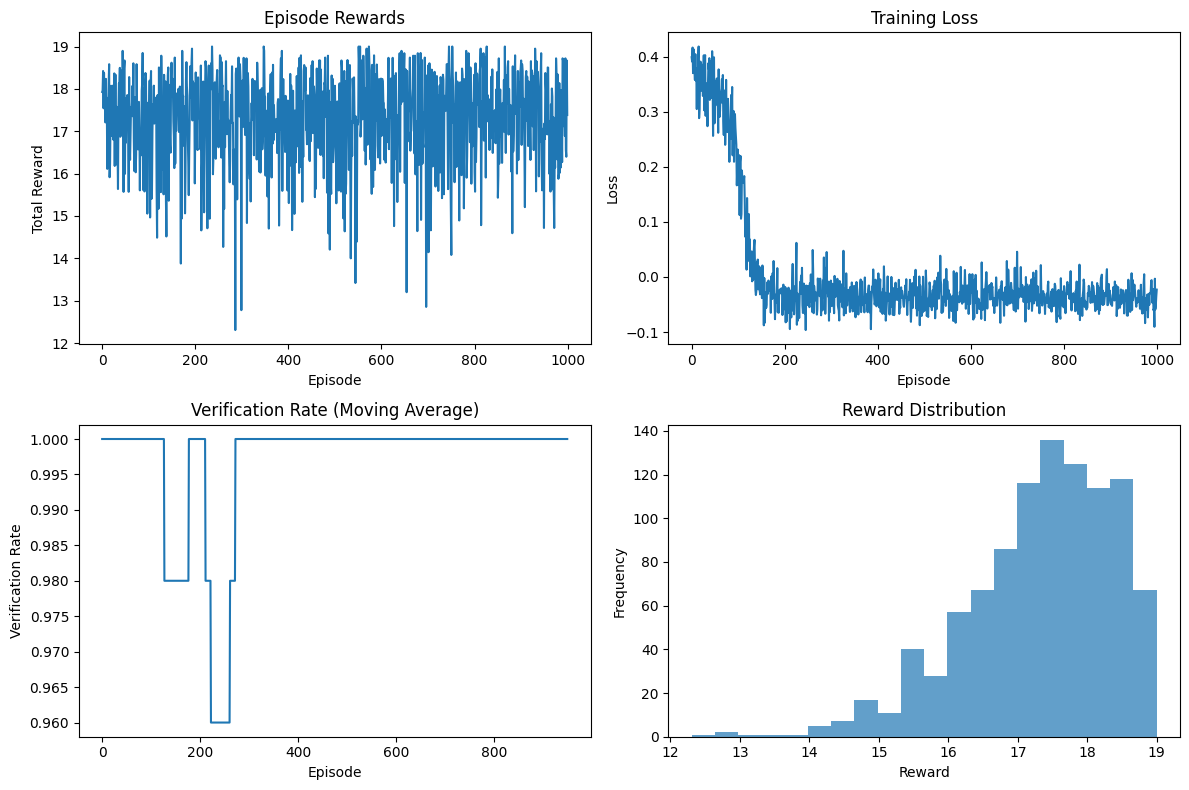


Testing trained model:
Test 1: Sequence [20, 29, 37, 21, 48, 23, 25, 38, 31, 5, 42, 8, 33, 33, 30, 16, 31, 1, 28, 48], Unique tokens: 17/20
Test 2: Sequence [44, 26, 31, 10, 47, 1, 36, 35, 5, 38, 27, 20, 17, 21, 32, 3, 11, 1, 38, 19], Unique tokens: 18/20
Test 3: Sequence [49, 33, 5, 37, 28, 12, 30, 38, 24, 41, 9, 50, 23, 0, 37, 2, 46, 10, 36, 10], Unique tokens: 18/20
Test 4: Sequence [16, 22, 14, 46, 40, 25, 45, 1, 23, 47, 9, 0, 40, 50, 32, 9, 24, 30, 38, 36], Unique tokens: 18/20
Test 5: Sequence [49, 23, 10, 16, 11, 44, 29, 26, 5, 49, 49, 17, 28, 3, 36, 9, 50, 28, 17, 39], Unique tokens: 16/20


In [10]:
def plot_training_results(rewards, losses, verification_rates):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

    # Plot rewards
    ax1.plot(rewards)
    ax1.set_title('Episode Rewards')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    # Plot losses
    ax2.plot(losses)
    ax2.set_title('Training Loss')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Loss')

    # Plot verification rate (moving average)
    window = 50
    verification_ma = [np.mean(verification_rates[i:i+window])
                      for i in range(len(verification_rates)-window)]
    ax3.plot(verification_ma)
    ax3.set_title('Verification Rate (Moving Average)')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Verification Rate')

    # Plot reward distribution
    ax4.hist(rewards, bins=20, alpha=0.7)
    ax4.set_title('Reward Distribution')
    ax4.set_xlabel('Reward')
    ax4.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_training_results(episode_rewards, losses, verification_rates)

# Test the trained model
def test_trained_model(model, num_tests=5):
    env = SimpleTextEnvironment()

    for i in range(num_tests):
        state = env.reset()
        generated_sequence = [state.item()]

        for step in range(env.max_length - 1):
            with torch.no_grad():
                probs = model.get_action_probabilities(state, temperature=0.8)
                action = torch.multinomial(probs, 1).item()

            next_state, reward, done = env.step(action)
            generated_sequence.append(action)
            state = next_state

            if done:
                break

        print(f"Test {i+1}: Sequence {generated_sequence}, "
              f"Unique tokens: {len(set(generated_sequence))}/{len(generated_sequence)}")

print("\nTesting trained model:")
test_trained_model(trained_model)

7. Advanced veRL Verification

In [11]:
class AdvancedVerification:
    def __init__(self, model):
        self.model = model
        self.safety_threshold = 0.1

    def verify_policy_improvement(self, old_probs, new_probs, advantages):
        """Advanced policy improvement verification"""
        # KL divergence check
        kl_div = torch.sum(old_probs * torch.log(old_probs / new_probs))

        # Advantage consistency check
        advantage_consistency = advantages.std() / (advantages.abs().mean() + 1e-8)

        # Policy improvement condition
        improvement_verified = (
            kl_div < self.safety_threshold and
            advantage_consistency < 2.0
        )

        return improvement_verified, {
            'kl_divergence': kl_div.item(),
            'advantage_consistency': advantage_consistency.item()
        }

    def safety_check(self, action_probs, state):
        """Safety constraints for language generation"""
        # Prevent extreme distributions
        entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-10))
        entropy_safe = entropy > 0.5  # Minimum entropy threshold

        # Prevent over-confident predictions
        max_prob = action_probs.max()
        confidence_safe = max_prob < 0.9

        return entropy_safe and confidence_safe

# Example usage in training
verification_module = AdvancedVerification(trained_model)